In [1]:
import cv2
import glob
import datetime
import matplotlib
import matplotlib.pyplot as plt
import imutils
%matplotlib inline

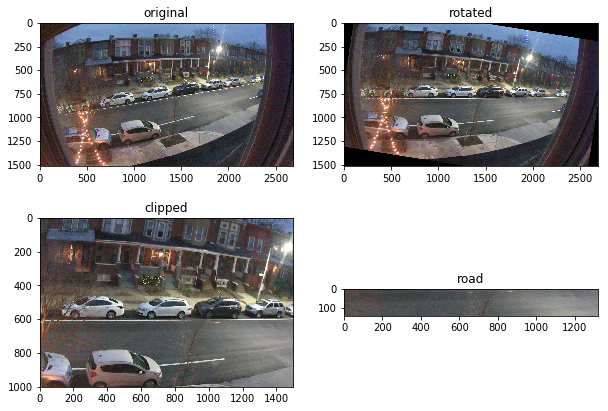

In [2]:
f = plt.figure(figsize=(10,7))

def show_im(n, im, title):
    ax = f.add_subplot(2,2, n)
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.set_title(title)

cal_path = "mounted-cars/calibration.jpg"
cal = cv2.flip(cv2.imread(cal_path), -1 ) #read & flip (camera mounted upside down)
show_im(1, cal, "original")

ROTATE_ANGLE = -9
rotated_cal = imutils.rotate(cal, angle=ROTATE_ANGLE) # rotate
show_im(2, rotated_cal, "rotated")

clipped = rotated_cal[200:1200, 500:2000] # clip
show_im(3, clipped, "clipped")

road = clipped[610:750, 180:2000] # clip
show_im(4, road, "road")

Text(0.5, 1.0, 'gray calibration road')

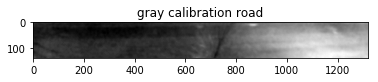

In [3]:
def crop_and_rotate(im):
    rotated = imutils.rotate(im, angle=ROTATE_ANGLE) # rotate
    return rotated[810:950, 680:2000] # clip

def read_road_image(path):
    im = cv2.imread(path)
    if im is None:
        return None
    flipped = cv2.flip(im, -1)
    cropped = crop_and_rotate(flipped)
    return cropped

def gray_and_blur(im):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return cv2.GaussianBlur(gray, (21, 21), 0)

cal_rotated = crop_and_rotate(cal)
background = gray_and_blur(cal_rotated)
plt.imshow(background, cmap='gray')
plt.title('gray calibration road')

In [4]:
import numpy as np
car_p1 = np.array([745, 881])
car_p2 = np.array([900, 856])
car_length_px = np.linalg.norm(car_p2 - car_p1)
px_2_m = lambda px: 1.93 * (px / car_length_px)
m_2_px = lambda m: (m / 1.93) * car_length_px
print("pixels per meter= {}".format(m_2_px(1)))
mps_2_mph = lambda mps: mps * 2.23694

pixels per meter= 81.34880035288904


In [5]:
import dateutil.parser

# for two frames
paths=[
    'mounted-cars/2018-12-27T17:07:10.167307.jpg',
    'mounted-cars/2018-12-27T17:07:10.792036.jpg',
]

# compare the time
def parse_time(path):
    time_s = path.split("mounted-cars/")[1][:-4]
    return dateutil.parser.parse(time_s)

def report_speed(delta_t, p0, p1):
    print("in {} sec".format(delta_t.total_seconds()))
    delta_p_pixels = np.linalg.norm(np.array(p1) - np.array(p0))
    print("drove {:.1f} px".format(delta_p_pixels))

    delta_p_m = px_2_m(delta_p_pixels)
    print("drove {:.2f} m".format(delta_p_m))

    speed_m = delta_p_m / delta_t.total_seconds()
    print("car speed {:.2f} MPH".format(mps_2_mph(speed_m)))

Text(0.5, 1.0, 'gray calibration road')

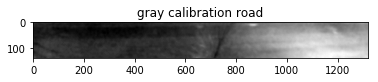

In [6]:
cal_rotated = crop_and_rotate(cal)
background = gray_and_blur(cal_rotated)
plt.imshow(background, cmap='gray')
plt.title('gray calibration road')

In [7]:
def ax_imshow(f, n, im, title, ticks=False):
    ax = f.add_subplot(4,1,n)
    ax.imshow(im, cmap='gray')
    ax.set_title(title)
    if not ticks:
        ax.set_xticks([])
        ax.set_yticks([])
    return ax

def process(path):
    color_im = read_road_image(path)
    if color_im is None: # some captured images are empty
        return
    im = gray_and_blur(color_im)

    background_subtracted = cv2.absdiff(background, im)
    thresh = cv2.threshold(background_subtracted, 25, 255, cv2.THRESH_BINARY)[1]
    
#     eroded = cv2.erode(thresh, None, iterations=2)
    eroded = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, None)

    cnts = cv2.findContours(eroded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    min_contour_area = 10_000
    contour_rectangles = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_contour_area:
            continue
        contour_rectangles.append(cv2.boundingRect(c))
    
    if len(contour_rectangles) == 0:
        return
    
    # otherwise, show figure
    f = plt.figure(figsize=(10,7))
    ax_imshow(f, 1, cv2.cvtColor(color_im, cv2.COLOR_BGR2RGB), "{} (base)".format(path), ticks=True)
    ax = ax_imshow(f, 2, eroded, "{} (label large countours)".format(path))
    for (x, y, w, h) in contour_rectangles:
        ax.add_patch(matplotlib.patches.Rectangle((x, y), w, h, color='magenta', fill=False, linewidth=2.0))

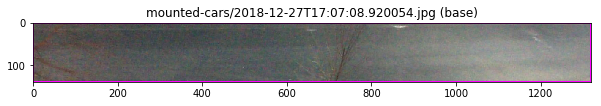

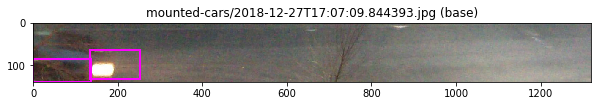

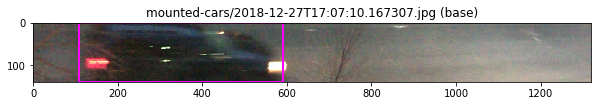

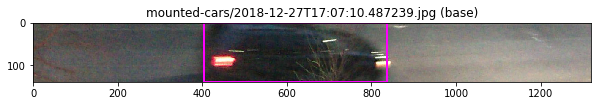

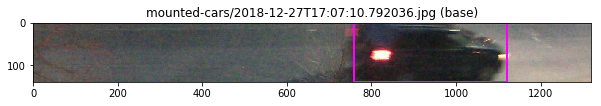

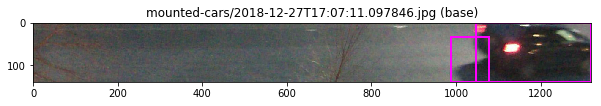

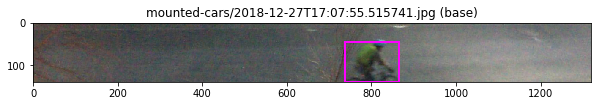

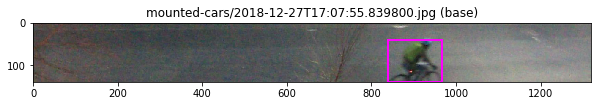

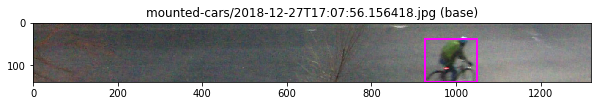

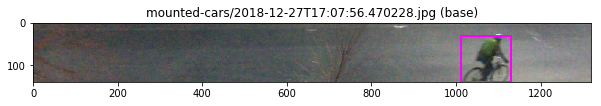

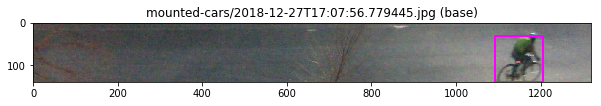

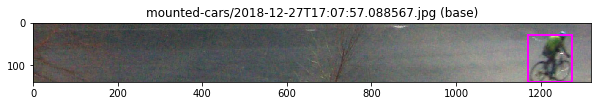

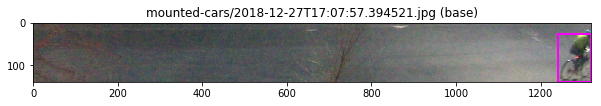

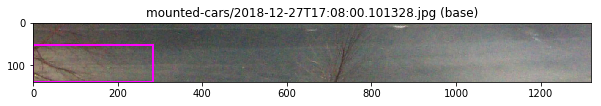

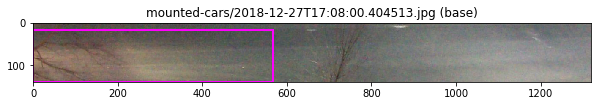

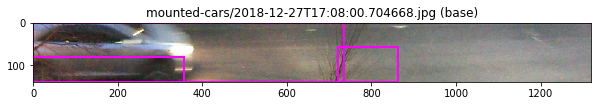

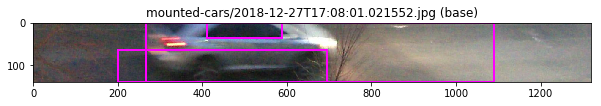

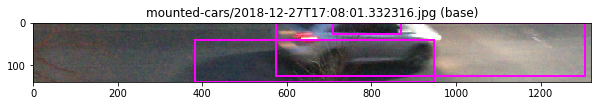

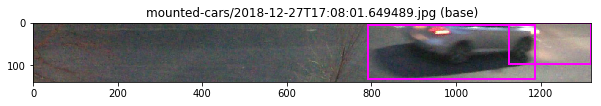

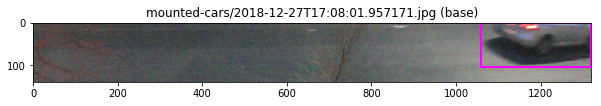

In [11]:
paths = glob.glob("mounted-cars/2018-*.jpg")
paths.sort()

fgbg = cv2.createBackgroundSubtractorMOG2()

for path in paths:
    color_im = read_road_image(path)
    if color_im is None: # some captured images are empty
        continue
    im = gray_and_blur(color_im)
    
    fgmask = fgbg.apply(im)
    
    res = cv2.bitwise_and(im, im, mask = fgmask)

    cnts = cv2.findContours(res.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    min_contour_area = 3_000
    contour_rectangles = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < min_contour_area:
            continue
        contour_rectangles.append(cv2.boundingRect(c))
    
    if len(contour_rectangles) == 0:
        continue

    # otherwise, show figure
    f = plt.figure(figsize=(10,7))
    ax = ax_imshow(f, 1, cv2.cvtColor(color_im, cv2.COLOR_BGR2RGB), "{} (base)".format(path), ticks=True)
    for (x, y, w, h) in contour_rectangles:
        ax.add_patch(matplotlib.patches.Rectangle((x, y), w, h, color='magenta', fill=False, linewidth=2.0))

In [9]:
t0 = parse_time(paths[0])
t1 = parse_time(paths[1])
delta_t = t1 - t0
report_speed(delta_t, (100, 680),(100, 1120))

in 0.300744 sec
drove 440.0 px
drove 5.41 m
car speed 40.23 MPH
